# exp023_rog_th10
remove_based_on_gtの対象追加  
'2021-04-21-US-MTV-1'→追加する（train:2021-04-28-US-MTV-1, 2021-04-29-US-MTV-1, osmnx）

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve
pd.set_option('display.max_rows', 100)

In [2]:
ro_th = 50 # 相対移動距離をもとにした異常値除去の閾値
rog_th = 10 # ground_truthをもとにした異常値除去の閾値

# ground_truthをもとにした異常値除去を行うcollection
rog_target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3',
              '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', '2021-03-16-US-RWC-2', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2',
              '2021-04-26-US-SVL-2', '2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1',
              '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1']

In [3]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [4]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [5]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [6]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [7]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [8]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [9]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [10]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [11]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

# speed0の分類モデル

In [12]:
def add_features(df):
    for c,i in itertools.product(['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM'], [1,2,3,-1,-2,-3]):
        col = c+ '_s' + str(i)
        df[col] = df[c].shift(i)
        df[col+'_diff'] = df[c] - df[col]
        df.loc[df['phone']!=df['phone'].shift(i), [col, col+'_diff']] = np.nan
    
    for c in ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']:
        df[c+'_s1_diff_sum'] = df[c+'_s1_diff'].fillna(0) + df[c+'_s-1_diff'].fillna(0)
        df[c+'_s2_diff_sum'] = df[c+'_s1_diff_sum'] + df[c+'_s2_diff'].fillna(0) + df[c+'_s-2_diff'].fillna(0)
        df[c+'_s3_diff_sum'] = df[c+'_s2_diff_sum'] + df[c+'_s3_diff'].fillna(0) + df[c+'_s-3_diff'].fillna(0)
    
    return df

In [13]:
train, test, sub, gt = get_data()
train = train.merge(gt[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'speedMps']], on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
train.loc[train['speedMps']==0.0, 'isSpeed0'] = 1
train['isSpeed0'] = train['isSpeed0'].fillna(0)
train = add_features(train)
test = add_features(test)

In [14]:
target = 'isSpeed0'
not_use_cols = ['speedMps', 'collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
                'latDeg_s1', 'latDeg_s2', 'latDeg_s3', 'latDeg_s-1', 'latDeg_s-2',
                'latDeg_s-3', 'lngDeg_s1', 'lngDeg_s2', 'lngDeg_s3', 'lngDeg_s-1',
                'lngDeg_s-2', 'lngDeg_s-3', 'heightAboveWgs84EllipsoidM_s1',
                'heightAboveWgs84EllipsoidM_s2', 'heightAboveWgs84EllipsoidM_s3',
                'heightAboveWgs84EllipsoidM_s-1', 'heightAboveWgs84EllipsoidM_s-2',
                'heightAboveWgs84EllipsoidM_s-3', target]
features = [c for c in train.columns if c not in not_use_cols]

opt_params = {'objective': 'binary', 
              'learning_rate': 0.1, 
              'seed': 42, 
              'feature_pre_filter': False, 
              'lambda_l1': 5.430530747001109e-05, 
              'lambda_l2': 3.4066721259729875, 
              'num_leaves': 136, 
              'feature_fraction': 0.8999999999999999, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 20, 
              'num_iterations': 20000, 
              'early_stopping_round': 100}

In [15]:
collections = train['collectionName'].unique()

oof = pd.DataFrame()
imp = pd.DataFrame()
test_preds = np.zeros(len(test))
n = len(collections)

for collection in collections:
    print('valid : ', collection)
    tr_idx = train[train['collectionName']!=collection].index
    vl_idx = train[train['collectionName']==collection].index
    tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
    vl_x, vl_y = train[features].iloc[vl_idx], train[target].iloc[vl_idx]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    
    model = lgb.train(opt_params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=20000, early_stopping_rounds=100, verbose_eval=100)
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    
    oof_tmp = train.iloc[vl_idx].copy()
    oof_tmp['pred'] = vl_pred
    oof = oof.append(oof_tmp)
    
    imp_tmp = pd.DataFrame()
    imp_tmp['feature'] = model.feature_name()
    imp_tmp['importance'] = model.feature_importance()
    imp_tmp['valid_collection'] = collection
    imp = imp.append(imp_tmp)
    
    pred = model.predict(test[features], num_iteration=model.best_iteration)
    test_preds += pred / n
test['pred'] = test_preds

valid :  2020-05-14-US-MTV-1
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0339981	valid_1's binary_logloss: 0.016154
[200]	training's binary_logloss: 0.0178696	valid_1's binary_logloss: 0.0155031
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0198739	valid_1's binary_logloss: 0.0153177
valid :  2020-05-14-US-MTV-2
[LightGBM] [Info] Number of positive: 23272, number of negative: 105723
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 128995, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.180410 -> initscore=-1.513572
[LightGBM] [Info] Start training from score -1.513572
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0335415	valid_1's binary_logloss: 0.031688

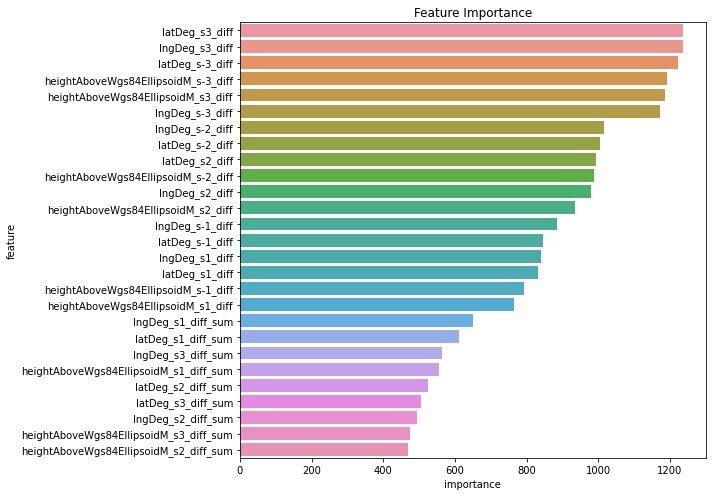

In [16]:
imp_mean = imp.groupby('feature').mean().reset_index()
plt.figure(figsize=(10, 7))
sns.barplot(x="importance", y="feature", data=imp_mean.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.tight_layout()

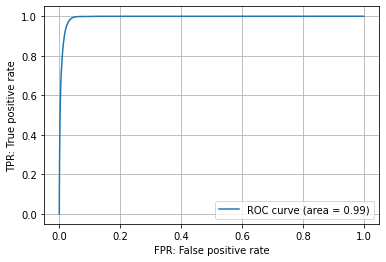

0.9938574434199423


In [17]:
fpr, tpr, thresholds = roc_curve(oof['isSpeed0'], oof['pred'])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()
print(auc)

<AxesSubplot:>

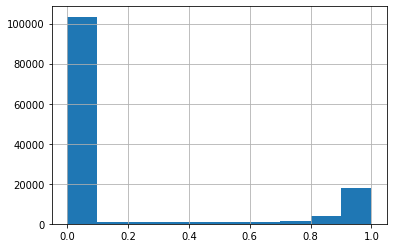

In [18]:
oof['pred'].hist()

In [19]:
os.makedirs(OUTPUT + '/speed0_pred/train', exist_ok=True)
phones = oof['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=2,sharex=True)
    tmp = oof[oof['phone']==phone].copy()

    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['speedMps'], label='speedMps')

    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['isSpeed0'], label='isSpeed0')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')

    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/speed0_pred/train/' + phone + '.png')
    plt.close()

In [20]:
os.makedirs(OUTPUT + '/speed0_pred/test', exist_ok=True)
phones = test['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=2,sharex=True)
    tmp = test[test['phone']==phone].copy()

    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')

    axes[0].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/speed0_pred/test/' + phone + '.png')
    plt.close()

In [21]:
train_sp0_pred = oof[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'pred']].copy()
test_sp0_pred = test[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'pred']].copy()

train_sp0_pred['isSpeed0'] = 0
test_sp0_pred['isSpeed0'] = 0
train_sp0_pred.loc[train_sp0_pred['pred']>0.5, 'isSpeed0'] = 1
test_sp0_pred.loc[test_sp0_pred['pred']>0.5, 'isSpeed0'] = 1

train_sp0_pred.to_csv(OUTPUT + '/train_sp0_pred.csv', index=False)
test_sp0_pred.to_csv(OUTPUT + '/test_sp0_pred.csv', index=False)

# 相対移動距離をもとにした外れ値除去

In [22]:
train, test, sub, gt = get_data()

In [23]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [24]:
# reject outlier
train = add_distance_diff(train)
train.loc[((train['dist_prev'] > ro_th) & (train['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan
train.to_csv(OUTPUT + '/train_ro.csv', index=False)

# ground_truthを基準にした外れ値除去

In [25]:
def get_osmnx_data():
    p = pathlib.Path(INPUT)
    files = list(p.glob('prep/osmnx/*.csv'))

    dfs = []
    for file in files:
        dfs.append(pd.read_csv(file))
    osmnx = pd.concat(dfs)

    return osmnx

In [26]:
def remove_based_on_gt(target_df, target_gt, th):
    osmnx_data = get_osmnx_data()
    target_gt = target_gt.append(osmnx_data)
    
    for idx in target_df.index:
        lat = target_df.at[idx, 'latDeg']
        lng = target_df.at[idx, 'lngDeg']
        s = target_df.at[idx, 'millisSinceGpsEpoch']
        
        if np.isnan(lat):
            continue
        else:
            target_gt['latDeg_pred'] = lat
            target_gt['lngDeg_pred'] = lng
            target_gt['dist'] = calc_haversine(target_gt['latDeg'], target_gt['lngDeg'], target_gt['latDeg_pred'], target_gt['lngDeg_pred'])
            closest_dist = target_gt['dist'].min()
            if closest_dist > th:
                target_df.at[idx, 'latDeg'] = np.nan
                target_df.at[idx, 'lngDeg'] = np.nan
    return target_df

In [27]:
def interpolate_remove_point(df):
    out_df = pd.DataFrame()
    collections = df['collectionName'].unique()
    
    for collection in collections:
        tmp = df[df['collectionName']==collection].copy()
        tmp = tmp.sort_values('millisSinceGpsEpoch')
        tmp = tmp.reset_index().set_index('millisSinceGpsEpoch')
        tmp[['latDeg', 'lngDeg']] = tmp[['latDeg', 'lngDeg']].interpolate(method='index', limit_area='inside')
        tmp = tmp.sort_values('index')
        tmp = tmp.reset_index().set_index('index')
        out_df = out_df.append(tmp)
    return out_df

In [28]:
rog_df = train[train['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
rog_df = interpolate_remove_point(rog_df)
train.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]
train.to_csv(OUTPUT + '/train_ro_rog.csv', index=False)

# speed0の処理

In [29]:
def sp0_process(df, sp0_result):
    df = df.merge(sp0_result, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    df['group'] = df.groupby('phone').cumcount()
    df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
    df['group'] = df['group'].fillna(method='ffill')
    df[['latDeg', 'lngDeg']] = df.groupby(['phone', 'group'])[['latDeg','lngDeg']].transform('mean')
    return df

In [30]:
train = sp0_process(train, train_sp0_pred)
train.to_csv(OUTPUT + '/train_ro_rog_sp0.csv', index=False)

# kalmanフィルタ

In [31]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [32]:
train = apply_kf_smoothing(train)
train.to_csv(OUTPUT + '/train_ro_rog_sp0_kf.csv', index=False)

# phones_mean

In [33]:
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')
    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])
    
    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)
    # Leave only records to be interpolated
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]
    
    return lerp_df[org_columns]

def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df

In [34]:
train_lerp = make_lerp_data(train)
train = calc_mean_pred(train, train_lerp)
train.to_csv(OUTPUT + '/train_ro_rog_sp0_kf_pm.csv', index=False)

# position_shift

In [35]:
train['phone'] = train['collectionName'] + '_' + train['phoneName']

In [36]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)

def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt
msge = 'millisSinceGpsEpoch'

In [37]:
def position_shift(df,a):

    d = df.copy()
    d['heightAboveWgs84EllipsoidM'] = 63.5
    d['x'], d['y'], d['z'] = zip(*d.apply(lambda x: WGS84_to_ECEF(x.latDeg, x.lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))

    #a = -0.2
    d.sort_values(['phone', msge], inplace=True)
    for fi in ['x','y','z']:
        d[[fi+'p']] = d[fi].shift().where(d['phone'].eq(d['phone'].shift()))
        d[[fi+'diff']] = d[fi]-d[fi+'p']
    #d[['yp']] = d['y'].shift().where(d['phone'].eq(d['phone'].shift()))
    d[['dist']] = np.sqrt(d['xdiff']**2 + d['ydiff']**2+ d['zdiff']**2)
    for fi in ['x','y','z']:
        d[[fi+'new']] = d[fi+'p'] + d[fi+'diff']*(1-a/d['dist'])
    lng, lat, alt = ECEF_to_WGS84(d['xnew'].values,d['ynew'].values,d['znew'].values)
    
    lng[np.isnan(lng)] = d.loc[np.isnan(lng),'lngDeg']
    lat[np.isnan(lat)] = d.loc[np.isnan(lat),'latDeg']
    d['latDeg'] = lat
    d['lngDeg'] = lng
    
    return d 

def objective(trial):
    a = trial.suggest_uniform('a', -1, 1)
    score = get_train_score(position_shift(train, a),gt)
    return score

In [38]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)
opt_a = study.best_params['a']
print(opt_a)

[I 2021-06-13 23:38:32,949] A new study created in memory with name: no-name-5a546512-76ca-4c39-8ab0-c62077abe855
[I 2021-06-13 23:38:37,198] Trial 0 finished with value: 3.9008428646267808 and parameters: {'a': -0.7206503285539372}. Best is trial 0 with value: 3.9008428646267808.
[I 2021-06-13 23:38:40,886] Trial 1 finished with value: 3.7477343349653904 and parameters: {'a': -0.40890351329704333}. Best is trial 1 with value: 3.7477343349653904.
[I 2021-06-13 23:38:44,663] Trial 2 finished with value: 3.7459765112463193 and parameters: {'a': -0.4049715382225514}. Best is trial 2 with value: 3.7459765112463193.
[I 2021-06-13 23:38:48,323] Trial 3 finished with value: 3.7822687498005148 and parameters: {'a': -0.489210252233645}. Best is trial 2 with value: 3.7459765112463193.
[I 2021-06-13 23:38:52,099] Trial 4 finished with value: 3.66367060516311 and parameters: {'a': -0.18381003042644628}. Best is trial 4 with value: 3.66367060516311.
[I 2021-06-13 23:38:55,754] Trial 5 finished with

0.41336840049736556


In [39]:
train = position_shift(train, opt_a)
train.to_csv(OUTPUT + '/train_ro_rog_sp0_kf_pm_ps.csv', index=False)

# trainの結果確認

In [40]:
for f in ['train_ro_rog_sp0_kf', 'train_ro_rog_sp0_kf_pm', 'train_ro_rog_sp0_kf_pm_ps']:
    print(f, get_train_score(pd.read_csv(OUTPUT + '/' + f + '.csv'), gt))

train_ro_rog_sp0_kf 3.896645628822954
train_ro_rog_sp0_kf_pm 3.61859053890038
train_ro_rog_sp0_kf_pm_ps 3.5666481153468506


In [41]:
result = train_result(train)

In [42]:
result.err

,percentile50,percentile95,p50_p90_mean
phone,,,
2020-05-14-US-MTV-1_Pixel4,1.206639,2.389000,1.797820
2020-05-14-US-MTV-1_Pixel4XLModded,1.093174,2.276498,1.684836
2020-05-14-US-MTV-2_Pixel4,1.614817,3.121311,2.368064
2020-05-14-US-MTV-2_Pixel4XLModded,1.722311,4.558673,3.140492
2020-05-21-US-MTV-1_Pixel4,1.755735,3.365986,2.560860
2020-05-21-US-MTV-2_Pixel4,0.632301,2.398346,1.515323
2020-05-21-US-MTV-2_Pixel4XL,0.592726,2.188846,1.390786
2020-05-29-US-MTV-1_Pixel4,2.148633,3.510171,2.829402
2020-05-29-US-MTV-1_Pixel4XL,1.933478,3.230472,2.581975


# make_sub

In [43]:
test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')

In [44]:
test = add_distance_diff(test)
test.loc[((test['dist_prev'] > ro_th) & (test['dist_next'] > ro_th)), ['latDeg', 'lngDeg']] = np.nan

In [45]:
rog_df = test[test['collectionName'].isin(rog_target)].copy()
rog_gt = gt[gt['collectionName'].isin(rog_target)].copy()
rog_df = remove_based_on_gt(rog_df, rog_gt, rog_th)
rog_df.to_csv(OUTPUT + '/test_rog.csv', index=False)
rog_df = interpolate_remove_point(rog_df)
test.loc[rog_df.index, ['latDeg', 'lngDeg']] = rog_df[['latDeg', 'lngDeg']]

In [46]:
test = sp0_process(test, test_sp0_pred)

In [47]:
test = apply_kf_smoothing(test)

In [48]:
test_lerp = make_lerp_data(test)
test = calc_mean_pred(test, test_lerp)

In [49]:
test['phone'] = test['collectionName'] + '_' + test['phoneName']

In [50]:
test = position_shift(test, opt_a)

In [51]:
assert len(test) == len(sub)

In [52]:
sub['latDeg'] = test['latDeg']
sub['lngDeg'] = test['lngDeg']
sub.to_csv(OUTPUT + f'/{nb_name}_submission.csv', index=False)